In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# Load datasets
users_df = pd.read_csv('data/users.csv')
listings_df = pd.read_csv('data/cleaned_listings.csv')
user_likes_df = pd.read_csv('data/user_likes.csv')

print("Users Dataset:")
print(f"Shape: {users_df.shape}")
print(users_df.head())
print("\n" + "="*50 + "\n")

print("Listings Dataset:")
print(f"Shape: {listings_df.shape}")
print(listings_df.head())
print("\n" + "="*50 + "\n")

print("User Likes Dataset:")
print(f"Shape: {user_likes_df.shape}")
print(user_likes_df.head())

Users Dataset:
Shape: (200, 4)
   user_id gender  age        education
0        1  Other   69  Post Graduation
1        2   Male   66  Post Graduation
2        3  Other   66      High School
3        4  Other   69     No Education
4        5   Male   29       Graduation


Listings Dataset:
Shape: (27250, 12)
   brokered_by    status     price  bed  bath  acre_lot     street  \
0      63921.0  for_sale  549000.0  4.0   4.0      5.00   705034.0   
1       3505.0  for_sale  175000.0  3.0   2.0      0.77  1793777.0   
2      88491.0  for_sale  118500.0  3.0   1.0      0.14  1143001.0   
3     108059.0  for_sale  489900.0  3.0   3.0     41.00  1729536.0   
4      56401.0  for_sale  350000.0  3.0   2.0     18.00  1859295.0   

         city    state  zip_code  house_size prev_sold_date  
0    Ranburne  Alabama   36273.0      2919.0            NaN  
1  Fort Payne  Alabama   35967.0      1234.0            NaN  
2  Fort Payne  Alabama   35967.0      1276.0     2021-05-25  
3     Henagar  Alabam

## Exploratory Data Analysis

Analyze the structure and relationships within the cleaned_listings dataset.

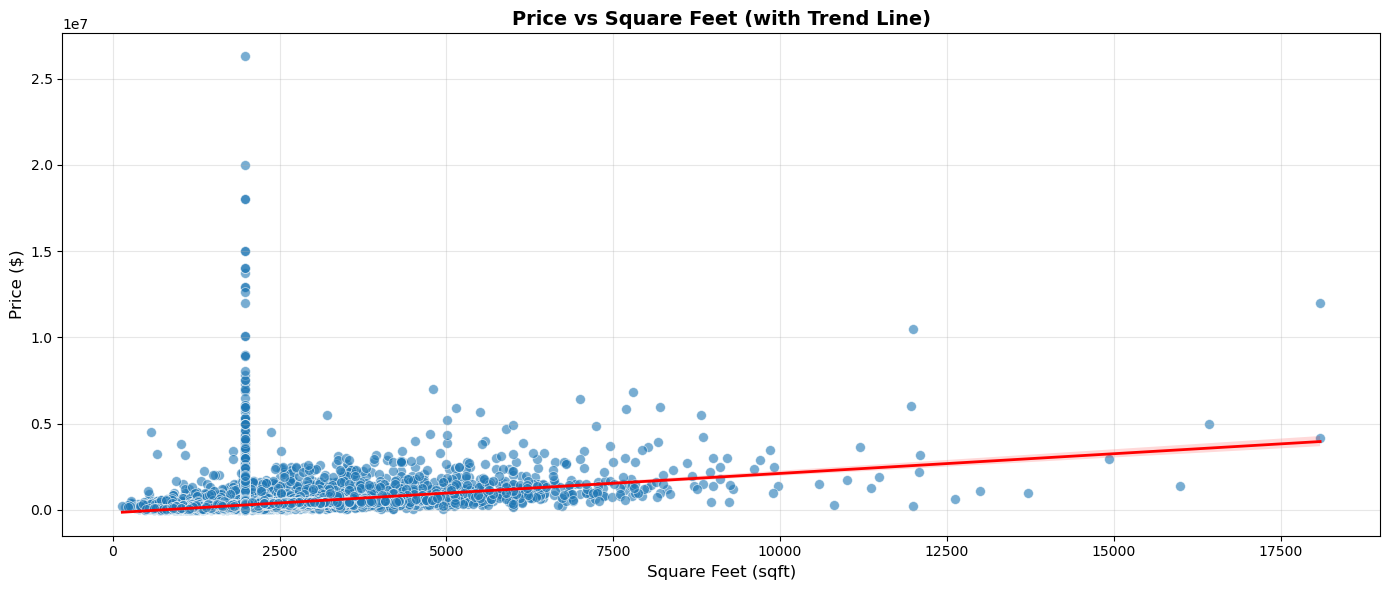


Price vs Sqft Correlation: 0.3437


In [9]:
# Scatterplot: Price vs Square Feet with trend line
plt.figure(figsize=(14, 6))
sns.scatterplot(data=listings_df, x='house_size', y='price', alpha=0.6, s=50)
sns.regplot(data=listings_df, x='house_size', y='price', scatter=False, color='red', line_kws={'linewidth': 2})
plt.title('Price vs Square Feet (with Trend Line)', fontsize=14, fontweight='bold')
plt.xlabel('Square Feet (sqft)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPrice vs Sqft Correlation: {listings_df['price'].corr(listings_df['house_size']):.4f}")


# Recommendation System Analysis